# 1. Introduction

* unique_key: A unique identifier for each collision.
* date, time: Date and time of the collision.
* borough: The borough, or area of New York City, where the collision occurred.
* location: Latitude and longitude coordinates for the collision.
* on_street, cross_street, off_street: Details of the street or intersection where the collision occurred.
* pedestrians_injured: Number of pedestrians who were injured.
* cyclist_injured: Number of people traveling on a bicycle who were injured.
* motorist_injured: Number of people traveling in a vehicle who were injured.
* total_injured: Total number of people injured.
* pedestrians_killed: Number of pedestrians who were killed.
* cyclist_killed: Number of people traveling on a bicycle who were killed.
* motorist_killed: Number of people traveling in a vehicle who were killed.
* total_killed: Total number of people killed.
* vehicle_1 through vehicle_5: Type of each vehicle involved in the accident.
* cause_vehicle_1 through cause_vehicle_5: Contributing factor for each vehicle in the accident.


In [1]:
import pandas as pd
mvc = pd.read_csv("nypd_mvc_2018.csv")

null_counts=mvc.isnull().sum()

# 2. Verifying the Total Columns

In [2]:
killed_cols = [col for col in mvc.columns if 'killed' in col]
killed = mvc[killed_cols].copy()

print(killed)

killed_manual_sum=killed.iloc[:,:3].sum(axis=1)

killed_mask=killed_manual_sum!=killed["total_killed"]

killed_non_eq=killed[killed_mask]

print(killed_non_eq)

       pedestrians_killed  cyclist_killed  motorist_killed  total_killed
0                       0               0                0           0.0
1                       0               0                0           0.0
2                       0               0                0           0.0
3                       0               0                0           0.0
4                       0               0                0           0.0
...                   ...             ...              ...           ...
57859                   0               0                0           0.0
57860                   0               0                0           0.0
57861                   0               0                0           0.0
57862                   0               0                0           0.0
57863                   0               0                0           0.0

[57864 rows x 4 columns]
       pedestrians_killed  cyclist_killed  motorist_killed  total_killed
3508                    0

# 3. Filling and Verifying the Killed and Injured Data

In [3]:
import numpy as np

# fix the killed values
killed['total_killed'] = killed['total_killed'].mask(killed['total_killed'].isnull(), killed_manual_sum)
killed['total_killed'] = killed['total_killed'].mask(killed['total_killed'] != killed_manual_sum, np.nan)

# Create an injured dataframe and manually sum values
injured = mvc[[col for col in mvc.columns if 'injured' in col]].copy()
injured_manual_sum = injured.iloc[:,:3].sum(axis=1)

injured["total_injured"]=injured["total_injured"].mask(injured["total_injured"].isnull(),injured_manual_sum)
injured["total_injured"]=injured["total_injured"].mask(injured["total_injured"]!=injured_manual_sum,np.nan)

# 4. Assigning the Corrected Data Back to the Main Dataframe

In [4]:
mvc["total_injured"]=injured["total_injured"]
mvc["total_killed"]=killed["total_killed"]

# 5. Visualizing Missing Data with Plots

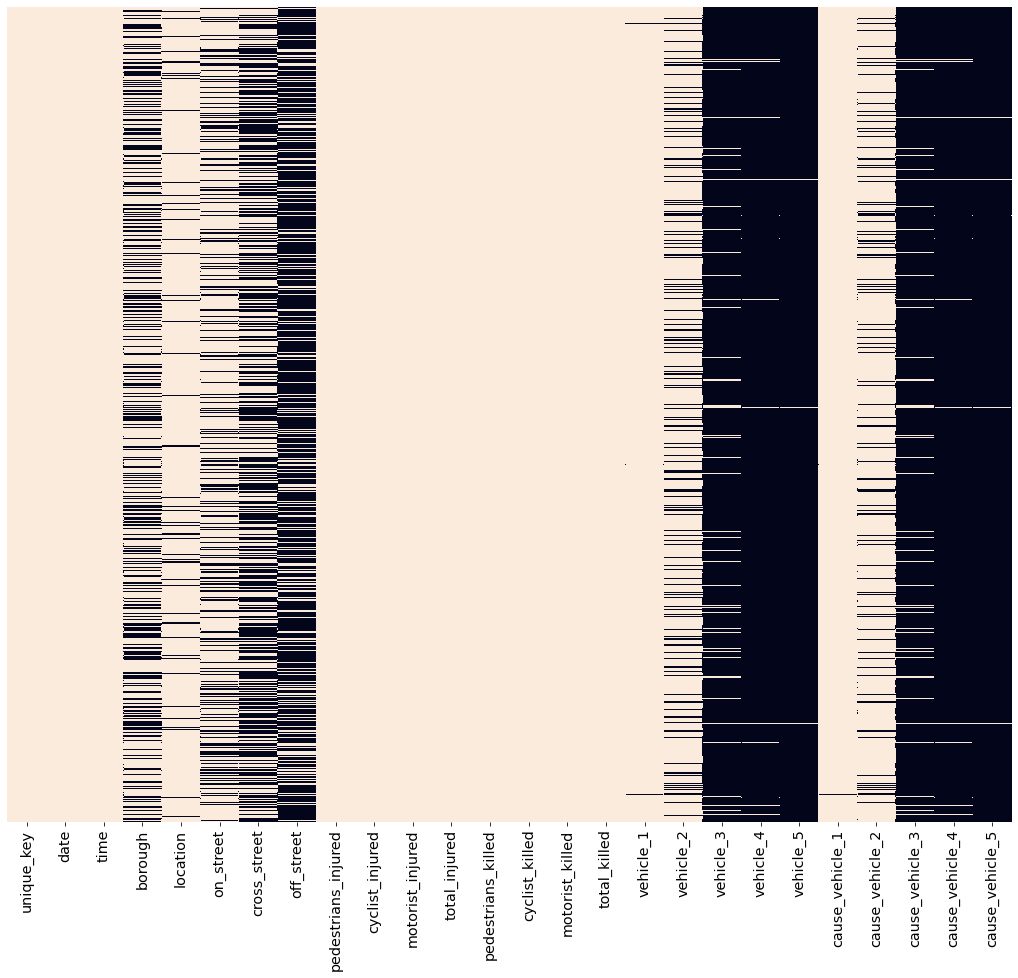

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_null_matrix(df, figsize=(18,15)):
    # initiate the figure
    plt.figure(figsize=figsize)
    # create a boolean dataframe based on whether values are null
    df_null = df.isnull()
    # create a heatmap of the boolean dataframe
    sns.heatmap(~df_null, cbar=False, yticklabels=False)
    plt.xticks(rotation=90, size='x-large')
    plt.show()
    
plot_null_matrix(mvc)

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_null_correlations(df):
    # create a correlation matrix only for columns with at least
    # one missing value
    cols_with_missing_vals = df.columns[df.isnull().sum() > 0]
    missing_corr = df[cols_with_missing_vals].isnull().corr()
    
    # create a mask to avoid repeated values and make
    # the plot easier to read
    missing_corr = missing_corr.iloc[1:, :-1]
    mask = np.triu(np.ones_like(missing_corr), k=1)
    
    # plot a heatmap of the values
    plt.figure(figsize=(20,14))
    ax = sns.heatmap(missing_corr, vmin=-1, vmax=1, cbar=False,
                     cmap='RdBu', mask=mask, annot=True)
    
    # format the text in the plot to make it easier to read
    for text in ax.texts:
        t = float(text.get_text())
        if -0.05 < t < 0.01:
            text.set_text('')
        else:
            text.set_text(round(t, 2))
        text.set_fontsize('x-large')
    plt.xticks(rotation=90, size='x-large')
    plt.yticks(rotation=0, size='x-large')

    plt.show()
    
vehicles=[col for col in mvc.columns if "vehicle" in col]
